In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles, make_classification, make_regression
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

Custom KMeans class

In [184]:
class CustomKMeans:
    def __init__(self, n_clusters=3, init='random', max_iter=300, tol=1e-4, random_state=None, n_init=10):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.n_init = n_init
        self.centroids = None
        self.labels_ = None
        self.cluster_centers_ = None

    #initializing the centroids
    def _initialize_centroids(self, X):
        rng = np.random.RandomState(self.random_state)
        if self.init == 'random':
            indices = rng.permutation(X.shape[0])[:self.n_clusters]
            return X[indices]
        #implementing k-means++
        elif self.init == 'k-means++':
            centroids = [X[rng.choice(X.shape[0])]]
            for _ in range(1, self.n_clusters):
                dist_sq = np.min([np.linalg.norm(X - c, axis=1)**2 for c in centroids], axis=0)
                probs = dist_sq / dist_sq.sum()
                cumulative_probs = np.cumsum(probs)
                r = rng.rand()
                next_idx = np.searchsorted(cumulative_probs, r)
                centroids.append(X[next_idx])
            return np.array(centroids)

    
    #assigning clusters
    def _assign_clusters(self, X, centroids):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        return np.argmin(distances, axis=1)

    #computing centroids
    def _compute_centroids(self, X, labels):
        return np.array([X[labels == i].mean(axis=0) if np.any(labels == i) else self.centroids[i]
                         for i in range(self.n_clusters)])

    def _has_converged(self, old_centroids, new_centroids):
        return np.linalg.norm(new_centroids - old_centroids) < self.tol

    def fit(self, X):
        X = np.asarray(X)
        best_inertia = np.inf
        best_centroids = None
        best_labels = None

        #Runs the KMeans algorithm n_init times and pick the best result
        for _ in range(self.n_init):
            self.centroids = self._initialize_centroids(X)

            for _ in range(self.max_iter):
                labels = self._assign_clusters(X, self.centroids)
                new_centroids = self._compute_centroids(X, labels)
                if self._has_converged(self.centroids, new_centroids):
                    break
                self.centroids = new_centroids

            inertia = np.sum((X - self.centroids[labels]) ** 2)

            #Keeps the best solution based on inertia
            if inertia < best_inertia:
                best_inertia = inertia
                best_centroids = self.centroids
                best_labels = labels

        self.centroids = best_centroids
        self.labels_ = best_labels
        self.cluster_centers_ = best_centroids
        return self

    def predict(self, X):
        X = np.asarray(X)
        return self._assign_clusters(X, self.centroids)

    def fit_predict(self, X):
        return self.fit(X).labels_

    def score(self, X):
        return silhouette_score(X, self.labels_)


Custom MiniBatchKMeans class

In [185]:
class CustomMiniBatchKMeans(CustomKMeans):
    def __init__(self, n_clusters=3, batch_size=100, **kwargs):
        super().__init__(n_clusters=n_clusters, **kwargs)
        self.batch_size = batch_size

    def fit(self, X):
        X = np.asarray(X)
        self.centroids = self._initialize_centroids(X)

        for _ in range(self.max_iter):
            mini_batch = X[np.random.choice(X.shape[0], self.batch_size)]
            labels = self._assign_clusters(mini_batch, self.centroids)
            for i in range(self.n_clusters):
                points = mini_batch[labels == i]
                if len(points) > 0:
                    self.centroids[i] = (self.centroids[i] + points.mean(axis=0)) / 2.0

        self.labels_ = self._assign_clusters(X, self.centroids)
        return self


Balanced Datasets

In [186]:
#dataset using make_blobs
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=42)

#dataset using make_moons
X_moons, _ = make_moons(n_samples=300, noise=0.08, random_state=42)

#dataset using make_circles
X_circles, _ = make_circles(n_samples=300, noise=0.05, factor=0.8, random_state=42)


Testing KMeans, KMeans++, MiniBatchKMeans against Sklearn using make_blobs dataset

Custom KMeans (Random Init) - Silhouette Score: 0.593
Sklearn KMeans (Random Init) - Silhouette Score: 0.649


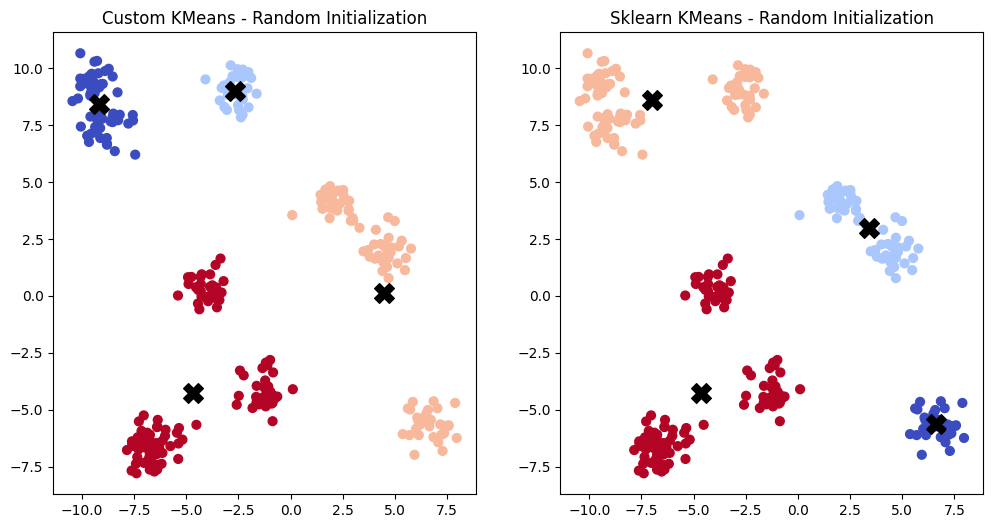

Custom KMeans (KMeans++ Init) - Silhouette Score: 0.649
Sklearn KMeans (KMeans++ Init) - Silhouette Score: 0.649


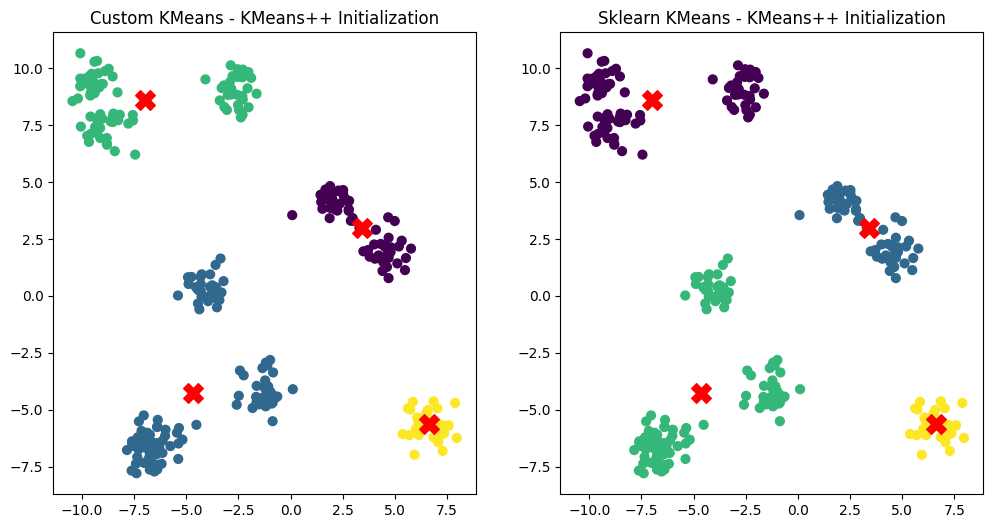

In [187]:

#Custom KMeans
kmeans_random = CustomKMeans(n_clusters=4, init='random', random_state=42)
random_labels = kmeans_random.fit_predict(X)
custom_random_score = kmeans_random.score(X)  # Silhouette score or custom method

#Sklearn KMeans
sklearn_kmeans_random = KMeans(n_clusters=4, init='random', random_state=42)
sklearn_random_labels = sklearn_kmeans_random.fit_predict(X)
sklearn_random_score = silhouette_score(X, sklearn_random_labels)

print(f"Custom KMeans (Random Init) - Silhouette Score: {custom_random_score:.3f}")
print(f"Sklearn KMeans (Random Init) - Silhouette Score: {sklearn_random_score:.3f}")

#Plotting the custom and sklearn KMeans 
plt.figure(figsize=(12, 6))

#Custom KMeans Random Init
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=random_labels, s=40, cmap='coolwarm')
plt.scatter(kmeans_random.centroids[:, 0], kmeans_random.centroids[:, 1], c='black', s=200, marker='X')
plt.title("Custom KMeans - Random Initialization")

#Sklearn KMeans Random Init
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=sklearn_random_labels, s=40, cmap='coolwarm')
plt.scatter(sklearn_kmeans_random.cluster_centers_[:, 0], sklearn_kmeans_random.cluster_centers_[:, 1], c='black', s=200, marker='X')
plt.title("Sklearn KMeans - Random Initialization")

plt.show()

#Custom KMeans KMeans++ Initialization
kmeans_pp = CustomKMeans(n_clusters=4, init='k-means++', random_state=42)
pp_labels = kmeans_pp.fit_predict(X)
custom_pp_score = kmeans_pp.score(X)  # Silhouette score or custom method

#Sklearn KMeans KMeans++ Initialization
sklearn_kmeans_pp = KMeans(n_clusters=4, init='k-means++', random_state=42)
sklearn_pp_labels = sklearn_kmeans_pp.fit_predict(X)
sklearn_pp_score = silhouette_score(X, sklearn_pp_labels)

print(f"Custom KMeans (KMeans++ Init) - Silhouette Score: {custom_pp_score:.3f}")
print(f"Sklearn KMeans (KMeans++ Init) - Silhouette Score: {sklearn_pp_score:.3f}")

#Plotting the custom and sklearn KMeans with KMeans++ init
plt.figure(figsize=(12, 6))

#Custom KMeans KMeans++ Init
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=pp_labels, s=40, cmap='viridis')
plt.scatter(kmeans_pp.centroids[:, 0], kmeans_pp.centroids[:, 1], c='red', s=200, marker='X')
plt.title("Custom KMeans - KMeans++ Initialization")

#Sklearn KMeans KMeans++ Init
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=sklearn_pp_labels, s=40, cmap='viridis')
plt.scatter(sklearn_kmeans_pp.cluster_centers_[:, 0], sklearn_kmeans_pp.cluster_centers_[:, 1], c='red', s=200, marker='X')
plt.title("Sklearn KMeans - KMeans++ Initialization")

plt.show()

random initialization performes worse on cluster_std lower than 0.5 and random_state = 0
kmeans++ performs worse on centers = 5 and 8

Custom Mini-Batch KMeans - Silhouette Score: 0.649
Sklearn Mini-Batch KMeans - Silhouette Score: 0.554


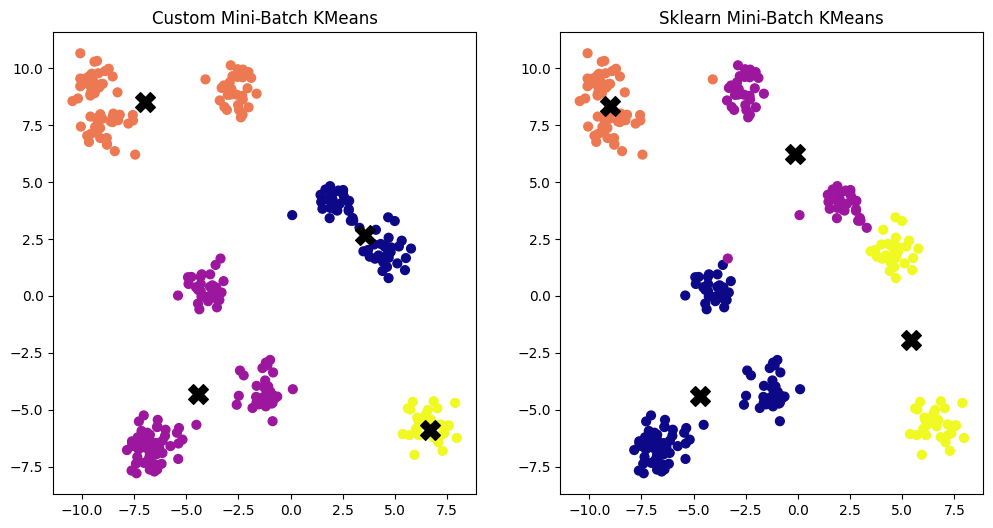

In [188]:
#Mini-Batch KMeans Comparison

# Custom Mini-Batch KMeans
mb_model = CustomMiniBatchKMeans(n_clusters=4, batch_size=50, init='k-means++', random_state=42)
mb_labels = mb_model.fit_predict(X)
custom_mb_score = mb_model.score(X)  #Silhouette score or custom method

# Sklearn Mini-Batch KMeans
sklearn_mb_model = MiniBatchKMeans(n_clusters=4, batch_size=50, init='k-means++', random_state=42)
sklearn_mb_labels = sklearn_mb_model.fit_predict(X)
sklearn_mb_score = silhouette_score(X, sklearn_mb_labels)

print(f"Custom Mini-Batch KMeans - Silhouette Score: {custom_mb_score:.3f}")
print(f"Sklearn Mini-Batch KMeans - Silhouette Score: {sklearn_mb_score:.3f}")

# Plotting Custom vs Sklearn Mini-Batch KMeans
plt.figure(figsize=(12, 6))

# Custom Mini-Batch KMeans
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=mb_labels, s=40, cmap='plasma')
plt.scatter(mb_model.centroids[:, 0], mb_model.centroids[:, 1], c='black', s=200, marker='X')
plt.title("Custom Mini-Batch KMeans")

# Sklearn Mini-Batch KMeans
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=sklearn_mb_labels, s=40, cmap='plasma')
plt.scatter(sklearn_mb_model.cluster_centers_[:, 0], sklearn_mb_model.cluster_centers_[:, 1], c='black', s=200, marker='X')
plt.title("Sklearn Mini-Batch KMeans")

plt.show()

Testing KMeans, KMeans++, MiniBatchKMeans against Sklearn using make_moons dataset

Custom KMeans (Random Init) - Silhouette Score: 0.484
Sklearn KMeans (Random Init) - Silhouette Score: 0.484


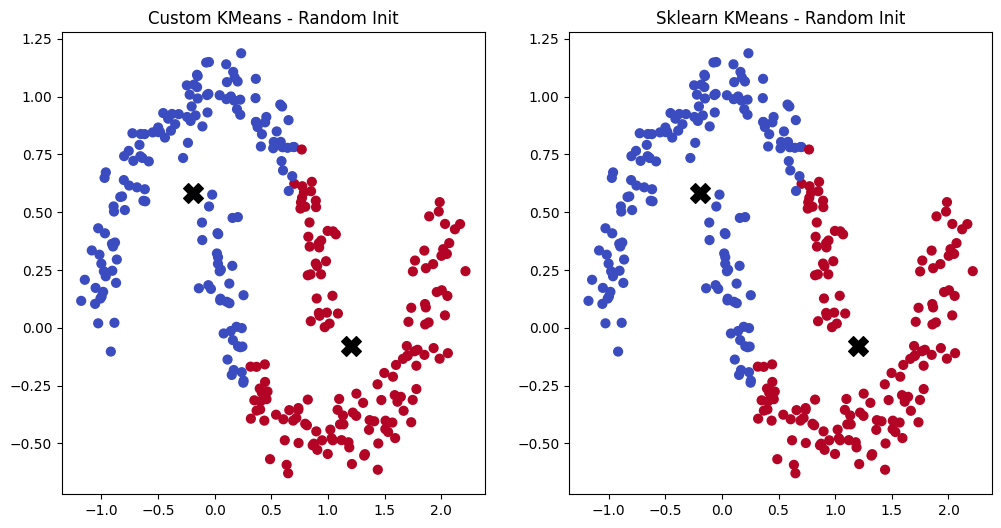

Custom KMeans (KMeans++ Init) - Silhouette Score: 0.484
Sklearn KMeans (KMeans++ Init) - Silhouette Score: 0.484


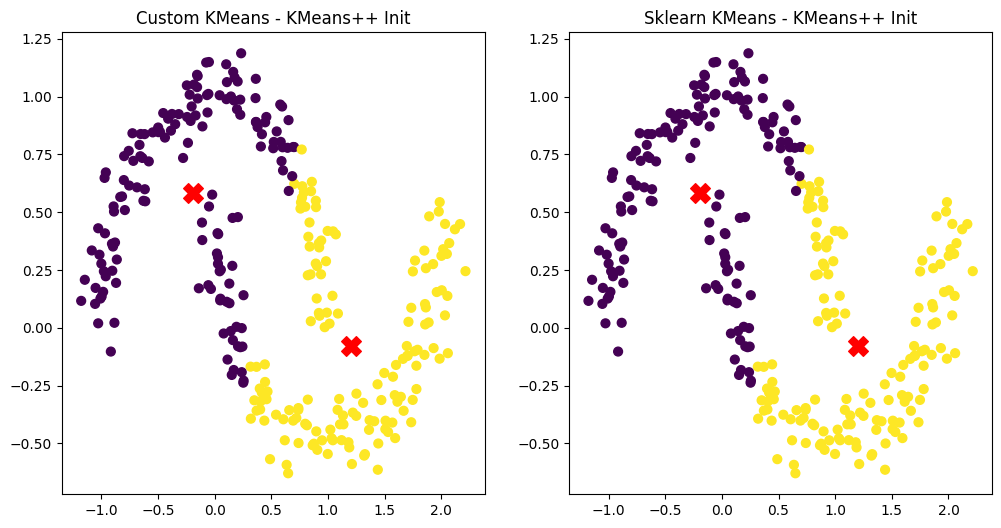

In [189]:
# KMeans 
kmeans_random = CustomKMeans(n_clusters=2, init='random', random_state=42)
random_labels = kmeans_random.fit_predict(X_moons)
custom_random_score = kmeans_random.score(X_moons)


sklearn_kmeans_random = KMeans(n_clusters=2, init='random', random_state=42)
sklearn_random_labels = sklearn_kmeans_random.fit_predict(X_moons)
sklearn_random_score = silhouette_score(X_moons, sklearn_random_labels)

print(f"Custom KMeans (Random Init) - Silhouette Score: {custom_random_score:.3f}")
print(f"Sklearn KMeans (Random Init) - Silhouette Score: {sklearn_random_score:.3f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=random_labels, s=40, cmap='coolwarm')
plt.scatter(kmeans_random.centroids[:, 0], kmeans_random.centroids[:, 1], c='black', s=200, marker='X')
plt.title("Custom KMeans - Random Init")

plt.subplot(1, 2, 2)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=sklearn_random_labels, s=40, cmap='coolwarm')
plt.scatter(sklearn_kmeans_random.cluster_centers_[:, 0], sklearn_kmeans_random.cluster_centers_[:, 1], c='black', s=200, marker='X')
plt.title("Sklearn KMeans - Random Init")

plt.show()


# KMeans++ 
kmeans_pp = CustomKMeans(n_clusters=2, init='k-means++', random_state=42)
pp_labels = kmeans_pp.fit_predict(X_moons)
custom_pp_score = kmeans_pp.score(X_moons)

sklearn_kmeans_pp = KMeans(n_clusters=2, init='k-means++', random_state=42)
sklearn_pp_labels = sklearn_kmeans_pp.fit_predict(X_moons)
sklearn_pp_score = silhouette_score(X_moons, sklearn_pp_labels)

print(f"Custom KMeans (KMeans++ Init) - Silhouette Score: {custom_pp_score:.3f}")
print(f"Sklearn KMeans (KMeans++ Init) - Silhouette Score: {sklearn_pp_score:.3f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=pp_labels, s=40, cmap='viridis')
plt.scatter(kmeans_pp.centroids[:, 0], kmeans_pp.centroids[:, 1], c='red', s=200, marker='X')
plt.title("Custom KMeans - KMeans++ Init")

plt.subplot(1, 2, 2)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=sklearn_pp_labels, s=40, cmap='viridis')
plt.scatter(sklearn_kmeans_pp.cluster_centers_[:, 0], sklearn_kmeans_pp.cluster_centers_[:, 1], c='red', s=200, marker='X')
plt.title("Sklearn KMeans - KMeans++ Init")

plt.show()





Custom Mini-Batch KMeans - Silhouette Score: 0.484
Sklearn Mini-Batch KMeans - Silhouette Score: 0.478


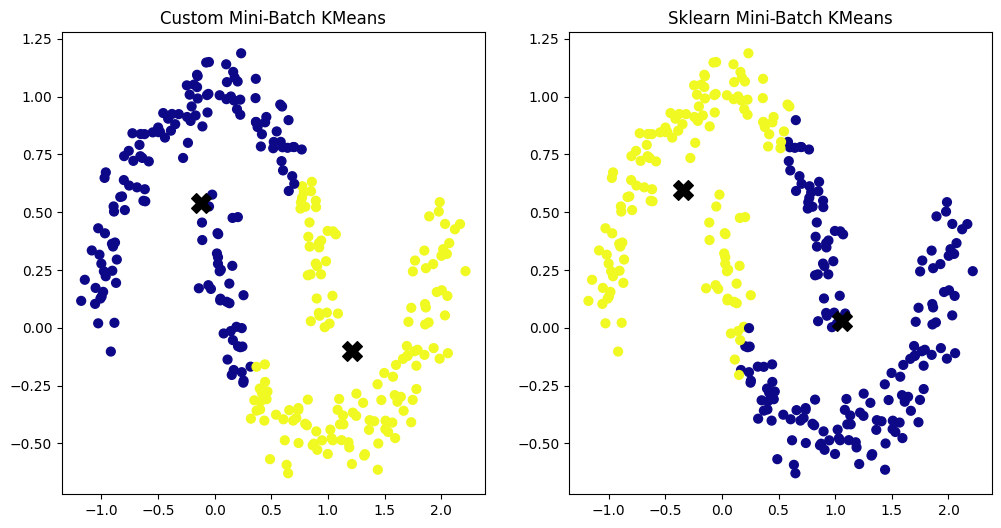

In [190]:
# Mini-Batch 
mb_model = CustomMiniBatchKMeans(n_clusters=2, batch_size=50, init='k-means++', random_state=42)
mb_labels = mb_model.fit_predict(X_moons)
custom_mb_score = mb_model.score(X_moons)

sklearn_mb_model = MiniBatchKMeans(n_clusters=2, batch_size=50, init='k-means++', random_state=42)
sklearn_mb_labels = sklearn_mb_model.fit_predict(X_moons)
sklearn_mb_score = silhouette_score(X_moons, sklearn_mb_labels)

print(f"Custom Mini-Batch KMeans - Silhouette Score: {custom_mb_score:.3f}")
print(f"Sklearn Mini-Batch KMeans - Silhouette Score: {sklearn_mb_score:.3f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=mb_labels, s=40, cmap='plasma')
plt.scatter(mb_model.centroids[:, 0], mb_model.centroids[:, 1], c='black', s=200, marker='X')
plt.title("Custom Mini-Batch KMeans")

plt.subplot(1, 2, 2)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=sklearn_mb_labels, s=40, cmap='plasma')
plt.scatter(sklearn_mb_model.cluster_centers_[:, 0], sklearn_mb_model.cluster_centers_[:, 1], c='black', s=200, marker='X')
plt.title("Sklearn Mini-Batch KMeans")

plt.show()

Testing KMeans, KMeans++, MiniBatchKMeans against Sklearn using make_circles dataset

Custom KMeans (Random Init) - Silhouette Score: 0.395
Sklearn KMeans (Random Init) - Silhouette Score: 0.401


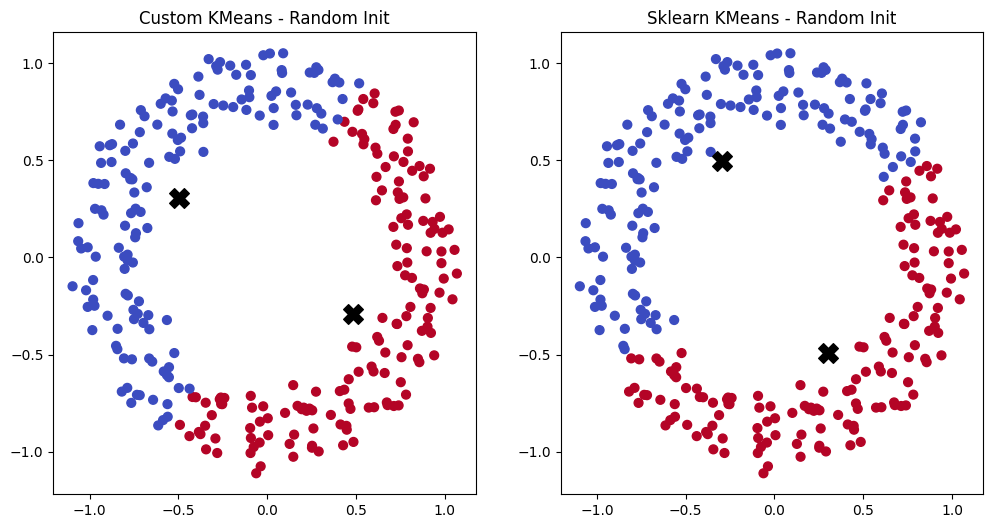

Custom KMeans (KMeans++ Init) - Silhouette Score: 0.398
Sklearn KMeans (KMeans++ Init) - Silhouette Score: 0.394


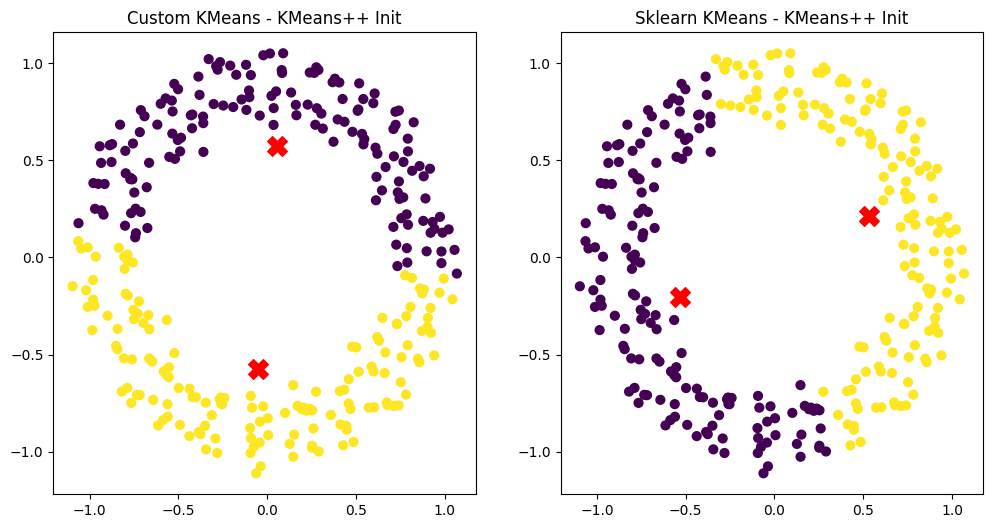

In [191]:
# KMeans Random Init 
kmeans_random = CustomKMeans(n_clusters=2, init='random', random_state=42)
random_labels = kmeans_random.fit_predict(X_circles)
custom_random_score = kmeans_random.score(X_circles)

sklearn_kmeans_random = KMeans(n_clusters=2, init='random', random_state=42)
sklearn_random_labels = sklearn_kmeans_random.fit_predict(X_circles)
sklearn_random_score = silhouette_score(X_circles, sklearn_random_labels)

print(f"Custom KMeans (Random Init) - Silhouette Score: {custom_random_score:.3f}")
print(f"Sklearn KMeans (Random Init) - Silhouette Score: {sklearn_random_score:.3f}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=random_labels, s=40, cmap='coolwarm')
plt.scatter(kmeans_random.centroids[:, 0], kmeans_random.centroids[:, 1], c='black', s=200, marker='X')
plt.title("Custom KMeans - Random Init")

plt.subplot(1, 2, 2)
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=sklearn_random_labels, s=40, cmap='coolwarm')
plt.scatter(sklearn_kmeans_random.cluster_centers_[:, 0], sklearn_kmeans_random.cluster_centers_[:, 1], c='black', s=200, marker='X')
plt.title("Sklearn KMeans - Random Init")
plt.show()

# KMeans++ init 
kmeans_pp = CustomKMeans(n_clusters=2, init='k-means++', random_state=42)
pp_labels = kmeans_pp.fit_predict(X_circles)
custom_pp_score = kmeans_pp.score(X_circles)

sklearn_kmeans_pp = KMeans(n_clusters=2, init='k-means++', random_state=42)
sklearn_pp_labels = sklearn_kmeans_pp.fit_predict(X_circles)
sklearn_pp_score = silhouette_score(X_circles, sklearn_pp_labels)

print(f"Custom KMeans (KMeans++ Init) - Silhouette Score: {custom_pp_score:.3f}")
print(f"Sklearn KMeans (KMeans++ Init) - Silhouette Score: {sklearn_pp_score:.3f}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=pp_labels, s=40, cmap='viridis')
plt.scatter(kmeans_pp.centroids[:, 0], kmeans_pp.centroids[:, 1], c='red', s=200, marker='X')
plt.title("Custom KMeans - KMeans++ Init")

plt.subplot(1, 2, 2)
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=sklearn_pp_labels, s=40, cmap='viridis')
plt.scatter(sklearn_kmeans_pp.cluster_centers_[:, 0], sklearn_kmeans_pp.cluster_centers_[:, 1], c='red', s=200, marker='X')
plt.title("Sklearn KMeans - KMeans++ Init")
plt.show()

Custom Mini-Batch KMeans - Silhouette Score: 0.401
Sklearn Mini-Batch KMeans - Silhouette Score: 0.398


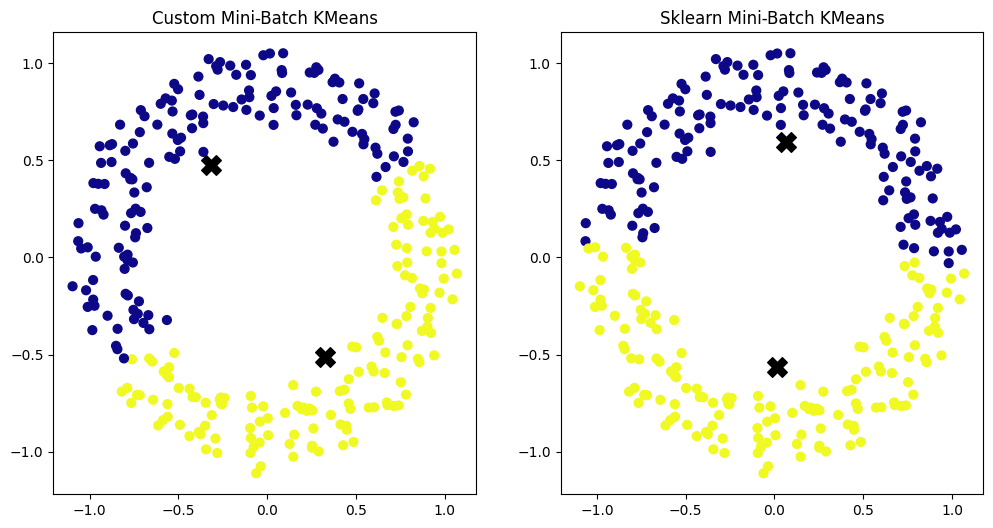

In [192]:
# Mini-Batch KMeans
mb_model = CustomMiniBatchKMeans(n_clusters=2, batch_size=50, init='k-means++', random_state=42)
mb_labels = mb_model.fit_predict(X_circles)
custom_mb_score = mb_model.score(X_circles)

sklearn_mb_model = MiniBatchKMeans(n_clusters=2, batch_size=50, init='k-means++', random_state=42)
sklearn_mb_labels = sklearn_mb_model.fit_predict(X_circles)
sklearn_mb_score = silhouette_score(X_circles, sklearn_mb_labels)

print(f"Custom Mini-Batch KMeans - Silhouette Score: {custom_mb_score:.3f}")
print(f"Sklearn Mini-Batch KMeans - Silhouette Score: {sklearn_mb_score:.3f}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=mb_labels, s=40, cmap='plasma')
plt.scatter(mb_model.centroids[:, 0], mb_model.centroids[:, 1], c='black', s=200, marker='X')
plt.title("Custom Mini-Batch KMeans")

plt.subplot(1, 2, 2)
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=sklearn_mb_labels, s=40, cmap='plasma')
plt.scatter(sklearn_mb_model.cluster_centers_[:, 0], sklearn_mb_model.cluster_centers_[:, 1], c='black', s=200, marker='X')
plt.title("Sklearn Mini-Batch KMeans")
plt.show()

Unbalanced Datasets (make_blobs)

In [193]:
#Create three clusters with different sample sizes
X_large, _ = make_blobs(n_samples=200, centers=[[0, 0]], cluster_std=1.0, random_state=42)
X_medium, _ = make_blobs(n_samples=70, centers=[[4, 4]], cluster_std=0.8, random_state=42)
X_small, _ = make_blobs(n_samples=30, centers=[[8, 0]], cluster_std=0.6, random_state=42)

#Combine datasets to create an imbalanced distribution
X_imbalanced = np.vstack((X_large, X_medium, X_small))
X_imbalanced = shuffle(X_imbalanced, random_state=42)



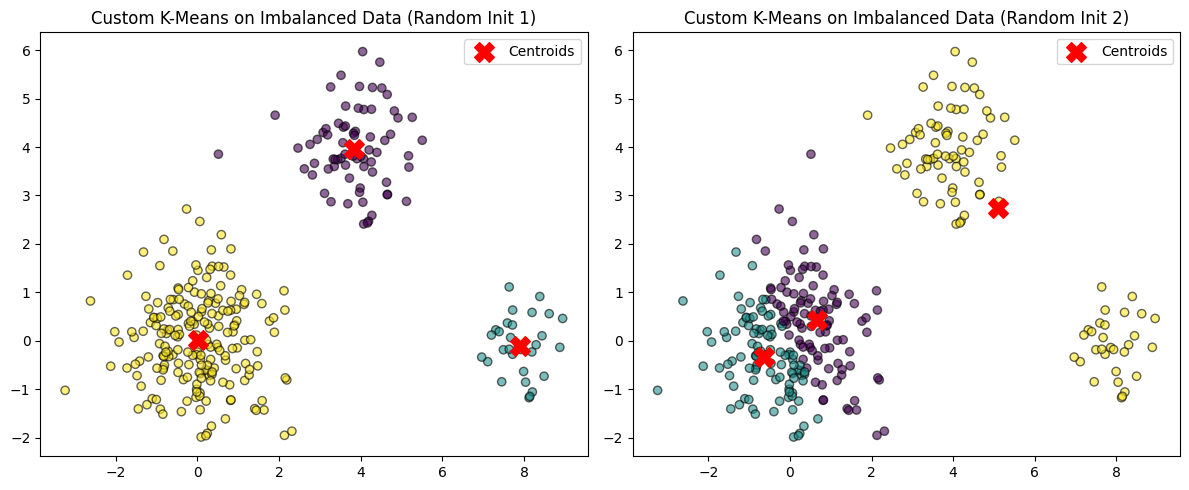

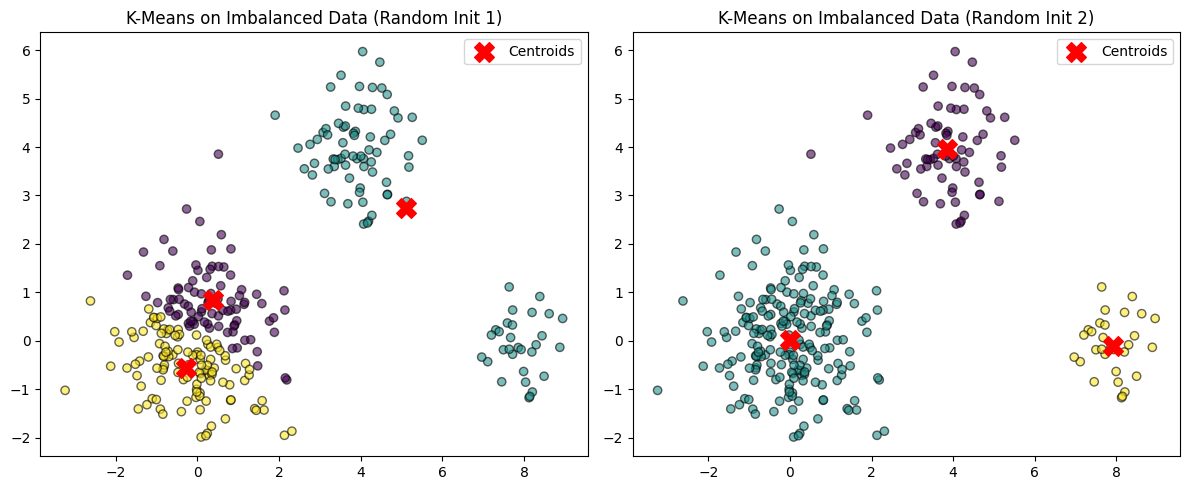

In [194]:
#Run K-Means with k=3
kmeans_imbalanced_1 = CustomKMeans(n_clusters=3, init='random', random_state=42, n_init=1)
kmeans_imbalanced_2 = CustomKMeans(n_clusters=3, init='random', random_state=1, n_init=1)

labels_imbalanced_1 = kmeans_imbalanced_1.fit_predict(X_imbalanced)
labels_imbalanced_2 = kmeans_imbalanced_2.fit_predict(X_imbalanced)

sk_kmeans_imbalanced_1 = KMeans(n_clusters=3, init='random', random_state=42, n_init=1)
sk_kmeans_imbalanced_2 = KMeans(n_clusters=3, init='random', random_state=1, n_init=1)

sk_labels_imbalanced_1 = sk_kmeans_imbalanced_1.fit_predict(X_imbalanced)
sk_labels_imbalanced_2 = sk_kmeans_imbalanced_2.fit_predict(X_imbalanced)

#Plot Custom KMeans for different sample sizes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(X_imbalanced[:, 0], X_imbalanced[:, 1], c=labels_imbalanced_1, cmap='viridis', edgecolors='k', alpha=0.6)
axes[0].scatter(kmeans_imbalanced_1.cluster_centers_[:, 0], kmeans_imbalanced_1.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
axes[0].set_title('Custom K-Means on Imbalanced Data (Random Init 1)')

axes[1].scatter(X_imbalanced[:, 0], X_imbalanced[:, 1], c=labels_imbalanced_2, cmap='viridis', edgecolors='k', alpha=0.6)
axes[1].scatter(kmeans_imbalanced_2.cluster_centers_[:, 0], kmeans_imbalanced_2.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
axes[1].set_title('Custom K-Means on Imbalanced Data (Random Init 2)')

for ax in axes:
    ax.legend()
plt.tight_layout()
plt.show()

#Plot Sklearn KMeans for different sample sizes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(X_imbalanced[:, 0], X_imbalanced[:, 1], c=sk_labels_imbalanced_1, cmap='viridis', edgecolors='k', alpha=0.6)
axes[0].scatter(sk_kmeans_imbalanced_1.cluster_centers_[:, 0], sk_kmeans_imbalanced_1.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
axes[0].set_title('K-Means on Imbalanced Data (Random Init 1)')

axes[1].scatter(X_imbalanced[:, 0], X_imbalanced[:, 1], c=sk_labels_imbalanced_2, cmap='viridis', edgecolors='k', alpha=0.6)
axes[1].scatter(sk_kmeans_imbalanced_2.cluster_centers_[:, 0], sk_kmeans_imbalanced_2.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
axes[1].set_title('K-Means on Imbalanced Data (Random Init 2)')

for ax in axes:
    ax.legend()
plt.tight_layout()
plt.show()

random_state = 1 for custom equal random_state = 42 for Sklearn and vise versa?
randomization issue?

Unbalanced Datasets (make_blobs (KMeans++))

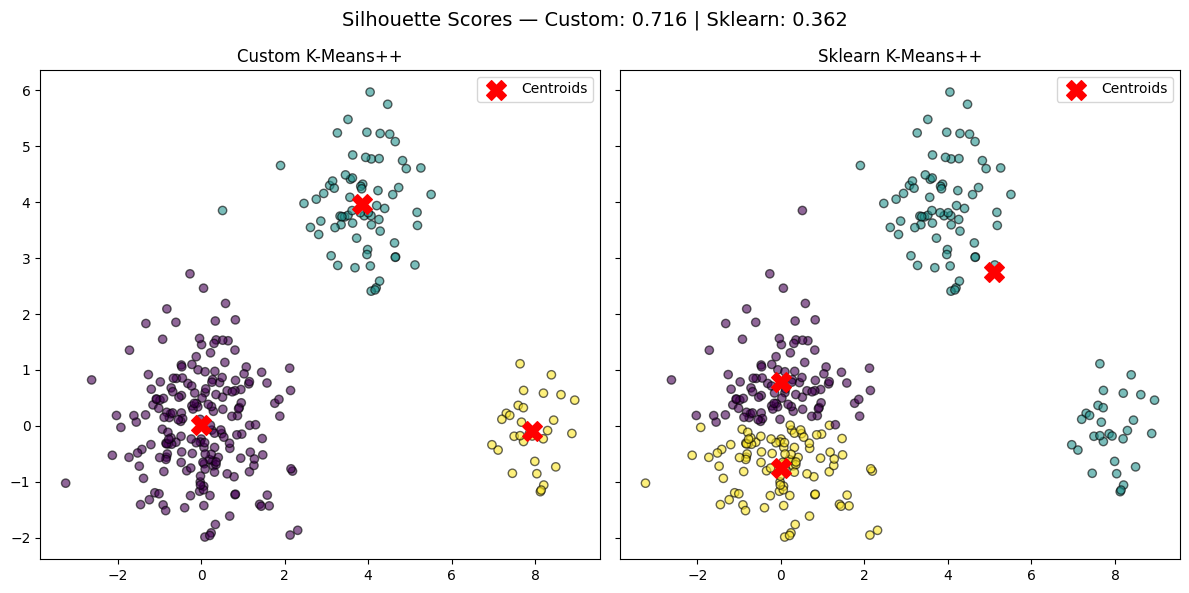

Custom KMeans++ Silhouette Score: 0.716
Sklearn KMeans++ Silhouette Score: 0.362


In [195]:
#Custom KMeans
kmeans_plus = CustomKMeans(n_clusters=3, init='k-means++', random_state=42, n_init=1)
kmeans_plus_labels = kmeans_plus.fit_predict(X_imbalanced)

#Sklearn KMeans
sk_kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=1)
sk_kmeans_labels = sk_kmeans.fit_predict(X_imbalanced)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

#Custom KMeans++ plot
axes[0].scatter(X_imbalanced[:, 0], X_imbalanced[:, 1], c=kmeans_plus_labels, cmap='viridis', edgecolors='k', alpha=0.6)
axes[0].scatter(kmeans_plus.cluster_centers_[:, 0], kmeans_plus.cluster_centers_[:, 1],
                c='red', marker='X', s=200, label='Centroids')
axes[0].set_title('Custom K-Means++')
axes[0].legend()

#Sklearn KMeans++ plot
axes[1].scatter(X_imbalanced[:, 0], X_imbalanced[:, 1], c=sk_kmeans_labels, cmap='viridis', edgecolors='k', alpha=0.6)
axes[1].scatter(sk_kmeans.cluster_centers_[:, 0], sk_kmeans.cluster_centers_[:, 1],
                c='red', marker='X', s=200, label='Centroids')
axes[1].set_title('Sklearn K-Means++')
axes[1].legend()

custom_score = silhouette_score(X_imbalanced, kmeans_plus_labels)
sklearn_score = silhouette_score(X_imbalanced, sk_kmeans_labels)

plt.suptitle(f'Silhouette Scores — Custom: {custom_score:.3f} | Sklearn: {sklearn_score:.3f}', fontsize=14)
plt.tight_layout()
plt.show()

print(f"Custom KMeans++ Silhouette Score: {custom_score:.3f}")
print(f"Sklearn KMeans++ Silhouette Score: {sklearn_score:.3f}")


Classification with Clustering vs Sklearn

In [196]:
#Load and split dataset
data = load_wine()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=42)

#Function to train and evaluate classifier with cluster labels
def train_with_clusters(kmeans, name):
    clusters_train = kmeans.fit_predict(X_train)
    clusters_test = kmeans.predict(X_test)
    
    X_train_aug = np.hstack([X_train, clusters_train.reshape(-1, 1)])
    X_test_aug = np.hstack([X_test, clusters_test.reshape(-1, 1)])
    
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_aug, y_train)
    preds = clf.predict(X_test_aug)
    acc = accuracy_score(y_test, preds)
    print(f"{name} KMeans ➤ Accuracy with cluster labels as feature: {acc:.3f}")

#Compare
train_with_clusters(CustomKMeans(n_clusters=3, init='k-means++', random_state=42), "Custom")
train_with_clusters(KMeans(n_clusters=3, init='k-means++', random_state=42), "Sklearn")


Custom KMeans ➤ Accuracy with cluster labels as feature: 1.000
Sklearn KMeans ➤ Accuracy with cluster labels as feature: 1.000


Continued Testing on Noisier data sets ( make_moons, make_circles)

In [197]:
def classification(dataset_fn, dataset_name):
    print(f"\nDataset: {dataset_name}")
    X, y = dataset_fn(n_samples=1000, noise=0.2, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    for label, kmeans in [
        ("Custom", CustomKMeans(n_clusters=2, init='k-means++', random_state=42)),
        ("Sklearn", KMeans(n_clusters=2, init='k-means++', random_state=42))
    ]:
        clusters_train = kmeans.fit_predict(X_train)
        clusters_test = kmeans.predict(X_test)

        # Add cluster labels as features
        X_train_aug = np.hstack([X_train, clusters_train.reshape(-1, 1)])
        X_test_aug = np.hstack([X_test, clusters_test.reshape(-1, 1)])

        clf = RandomForestClassifier(random_state=42)
        clf.fit(X_train_aug, y_train)
        preds = clf.predict(X_test_aug)
        acc = accuracy_score(y_test, preds)

        print(f"{label} KMeans ➤ Accuracy with cluster features: {acc:.3f}")

#Run tests
classification(make_moons, "Make Moons")
classification(make_circles, "Make Circles")



Dataset: Make Moons
Custom KMeans ➤ Accuracy with cluster features: 0.984
Sklearn KMeans ➤ Accuracy with cluster features: 0.984

Dataset: Make Circles
Custom KMeans ➤ Accuracy with cluster features: 0.552
Sklearn KMeans ➤ Accuracy with cluster features: 0.568


Testing for Regression against Sklearn

In [198]:
def cluster_regression(dataset_fn, dataset_name):
    print(f"Regression Dataset: {dataset_name}")
    X, y = dataset_fn(n_samples=1000, n_features=5, noise=0.1, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    for label, kmeans in [
        ("Custom", CustomKMeans(n_clusters=3, init='k-means++', random_state=42)),
        ("Sklearn", KMeans(n_clusters=3, init='k-means++', random_state=42))
    ]:
        clusters_train = kmeans.fit_predict(X_train)
        clusters_test = kmeans.predict(X_test)

        #Add cluster labels as features
        X_train_aug = np.hstack([X_train, clusters_train.reshape(-1, 1)])
        X_test_aug = np.hstack([X_test, clusters_test.reshape(-1, 1)])

        #Train the regressor
        reg = RandomForestRegressor(random_state=42)
        reg.fit(X_train_aug, y_train)
        
        #Predict and evaluate
        preds = reg.predict(X_test_aug)
        mse = mean_squared_error(y_test, preds)
        
        print(f"{label} KMeans ➤ Mean Squared Error with cluster features: {mse:.3f}")

#Run tests
cluster_regression(make_regression, "Make Regression")


Regression Dataset: Make Regression
Custom KMeans ➤ Mean Squared Error with cluster features: 317.594
Sklearn KMeans ➤ Mean Squared Error with cluster features: 309.406


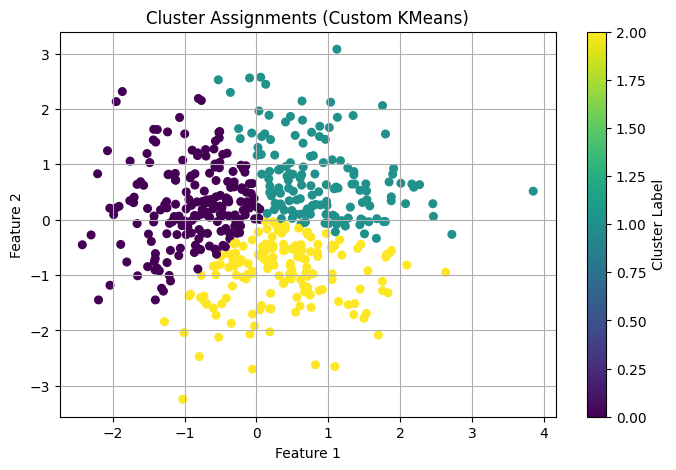

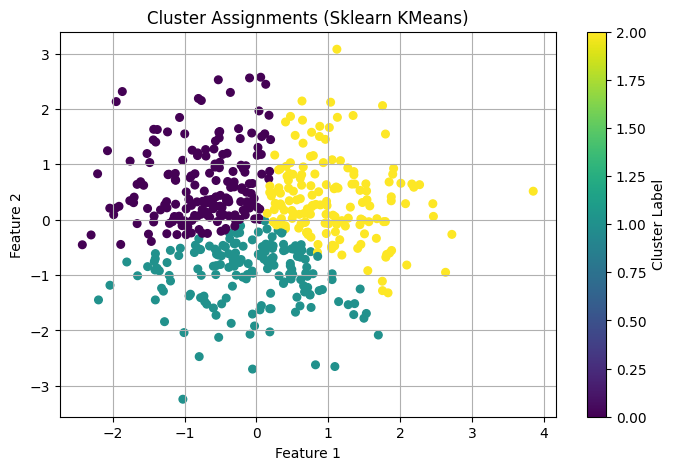

In [199]:
#dataset
X, y = make_regression(n_samples=500, n_features=2, noise=10.0, random_state=42)

X_train = X
y_train = y

#Run KMeans
kmeans = CustomKMeans(n_clusters=3, init='k-means++', random_state=42)
clusters_train = kmeans.fit_predict(X_train)

sk_kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
sk_clusters_train = sk_kmeans.fit_predict(X_train) 

#Visualize cluster assignments colored by target
plt.figure(figsize=(8, 5))
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=clusters_train, cmap='viridis', s=30)
plt.colorbar(scatter, label="Cluster Label")
plt.title("Cluster Assignments (Custom KMeans)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=sk_clusters_train, cmap='viridis', s=30)
plt.colorbar(scatter, label="Cluster Label")
plt.title("Cluster Assignments (Sklearn KMeans)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()


Objective Fuctions, Loss function, heuristics

In [200]:
#Objective Function (Manhattan Distance - minimize L1 norm) (absolute difference)
class KMeansL1(CustomKMeans):
    def _assign_clusters(self, X, centroids):
        distances = np.sum(np.abs(X[:, np.newaxis] - centroids), axis=2)
        return np.argmin(distances, axis=1)

    def _compute_centroids(self, X, labels):
        return np.array([
            np.median(X[labels == i], axis=0) if np.any(labels == i) else self.centroids[i]
            for i in range(self.n_clusters)
        ])

In [201]:
#Heuristic (Elkan's Algorithm - more efficiency that regular KMeans)
class KMeansElkan(CustomKMeans):
    def fit(self, X):
        n_samples, n_features = X.shape
        self.centroids = self._initialize_centroids(X)
        upper_bounds = np.full((n_samples, self.n_clusters), np.inf)
        lower_bounds = np.zeros((n_samples, self.n_clusters))
        labels = np.zeros(n_samples, dtype=int)

        for iteration in range(self.max_iter):
            centroids_old = self.centroids.copy()
            centroid_shifts = np.linalg.norm(self.centroids[:, np.newaxis] - self.centroids, axis=2)
            half_shifts = 0.5 * np.min(centroid_shifts + np.eye(self.n_clusters) * np.max(centroid_shifts), axis=1)

            for i in range(n_samples):
                skip = True
                for j in range(self.n_clusters):
                    if j == labels[i]:
                        continue
                    if upper_bounds[i, labels[i]] > lower_bounds[i, j] and \
                       upper_bounds[i, labels[i]] > 0.5 * np.linalg.norm(self.centroids[labels[i]] - self.centroids[j]):
                        skip = False
                        break

                if skip:
                    continue

                dists = np.linalg.norm(X[i] - self.centroids, axis=1)
                labels[i] = np.argmin(dists)
                upper_bounds[i, :] = dists
                lower_bounds[i, :] = np.abs(dists - dists[labels[i]])

            self.centroids = self._compute_centroids(X, labels)
            if np.allclose(self.centroids, centroids_old, atol=self.tol):
                break

        self.labels_ = labels
        return self

In [202]:
#Loss Function when direction is more important that magnitude
class KMeansCosine(CustomKMeans):
    def _assign_clusters(self, X, centroids):
        X_norm = normalize(X)
        centroids_norm = normalize(centroids)
        similarity = np.dot(X_norm, centroids_norm.T)
        return np.argmax(similarity, axis=1)

    def _compute_centroids(self, X, labels):
        return np.array([
            normalize([X[labels == i].mean(axis=0)])[0] if np.any(labels == i) else self.centroids[i]
            for i in range(self.n_clusters)
        ])

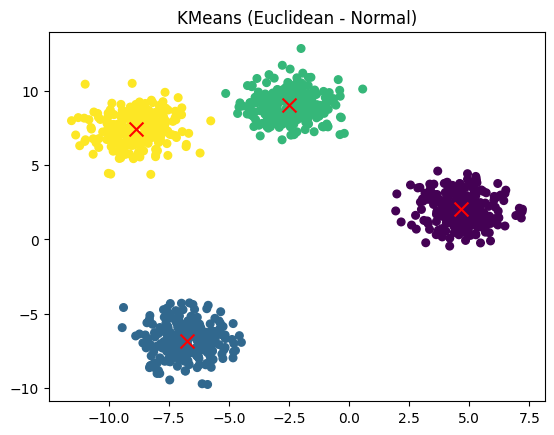

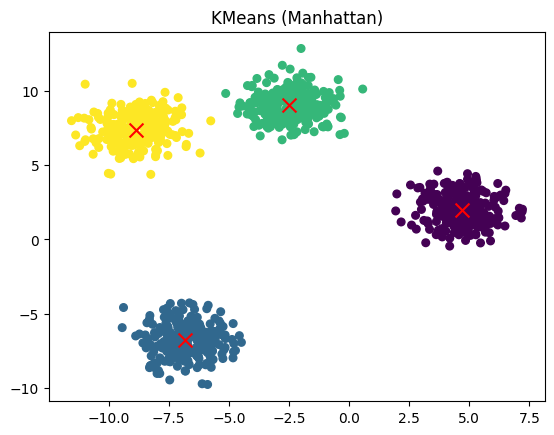

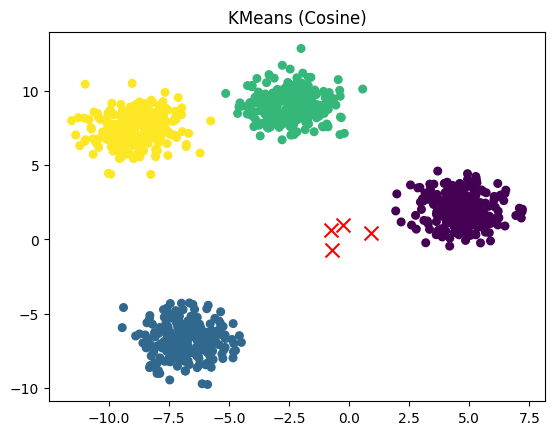

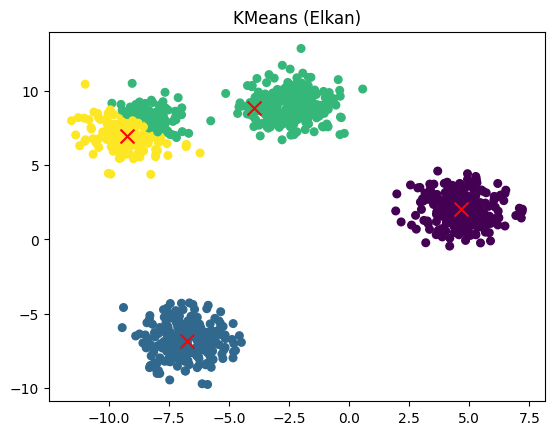

Silhouette Scores:
KMeans (Euclidean - Normal): 0.792
KMeans (Manhattan): 0.792
KMeans (Cosine): 0.792
KMeans (Elkan): 0.656


In [203]:
#Generate synthetic data using make_blobs
X, y = make_blobs(n_samples=1000, centers=4, random_state=42)

# Define models
models = {
    'KMeans (Euclidean - Normal)': CustomKMeans(n_clusters=4, init='k-means++', random_state=0),
    'KMeans (Manhattan)': KMeansL1(n_clusters=4, init='k-means++', random_state=0),
    'KMeans (Cosine)': KMeansCosine(n_clusters=4, init='k-means++', random_state=0),
    'KMeans (Elkan)': KMeansElkan(n_clusters=4, init='k-means++', random_state=0)
}

#Store silhouette scores
scores = {}

#Test each model and plot
for name, model in models.items():
    model.fit(X)
    
    #Compute silhouette score instead of inertia
    score = silhouette_score(X, model.labels_)
    scores[name] = score
    
    #Plot clustering result
    plt.scatter(X[:, 0], X[:, 1], c=model.labels_, cmap='viridis', s=30)
    plt.scatter(model.centroids[:, 0], model.centroids[:, 1], c='red', marker='x', s=100)
    plt.title(name)
    plt.show()

#Print silhouette scores for each model
print("Silhouette Scores:")
for name, score in scores.items():
    print(f"{name}: {score:.3f}")


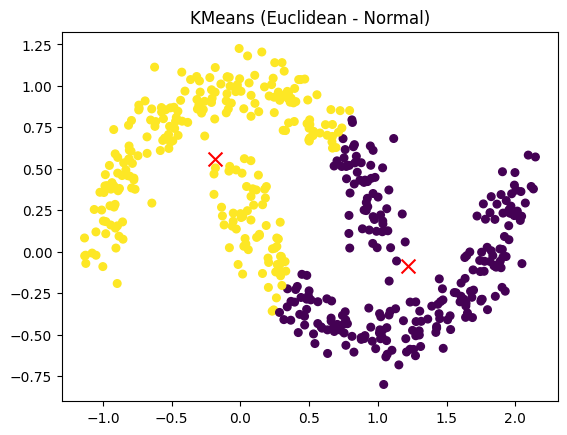

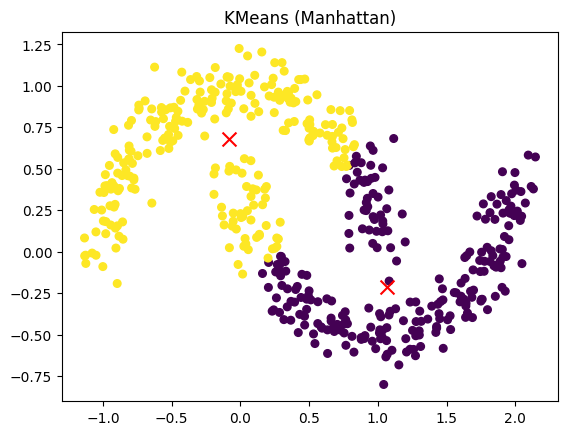

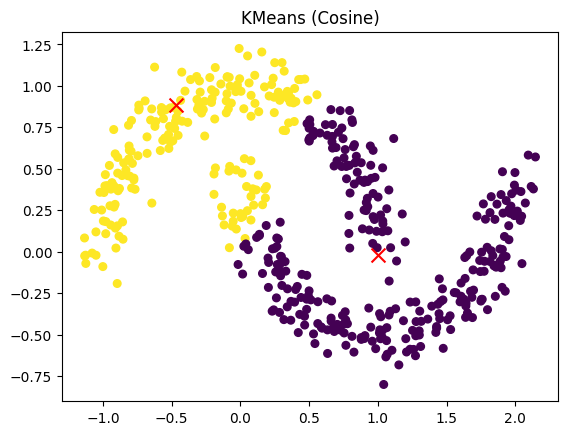

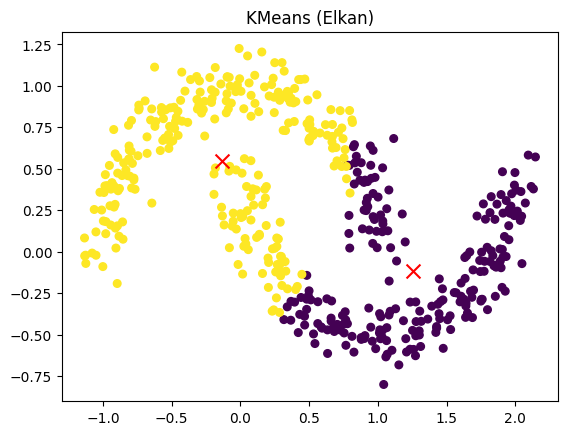

Silhouette Scores:
KMeans (Euclidean - Normal): 0.484
KMeans (Manhattan): 0.481
KMeans (Cosine): 0.473
KMeans (Elkan): 0.480


In [204]:
#data
X, _ = make_moons(n_samples=500, noise=0.1, random_state=0)

#Run and visualize each model
models = {
    'KMeans (Euclidean - Normal)': CustomKMeans(n_clusters=2, init='k-means++', random_state=0),
    'KMeans (Manhattan)': KMeansL1(n_clusters=2, init='k-means++', random_state=0),
    'KMeans (Cosine)': KMeansCosine(n_clusters=2, init='k-means++', random_state=0),
    'KMeans (Elkan)': KMeansElkan(n_clusters=2, init='k-means++', random_state=0)
}

from sklearn.metrics import silhouette_score

scores = {}
for name, model in models.items():
    model.fit(X)
    labels = model.labels_
    score = silhouette_score(X, labels)
    scores[name] = score

    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30)
    plt.scatter(model.centroids[:, 0], model.centroids[:, 1], c='red', marker='x', s=100)
    plt.title(name)
    plt.show()

print("Silhouette Scores:")
for name, score in scores.items():
    print(f"{name}: {score:.3f}")


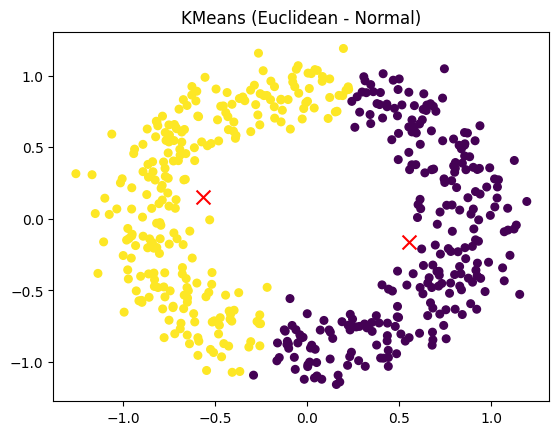

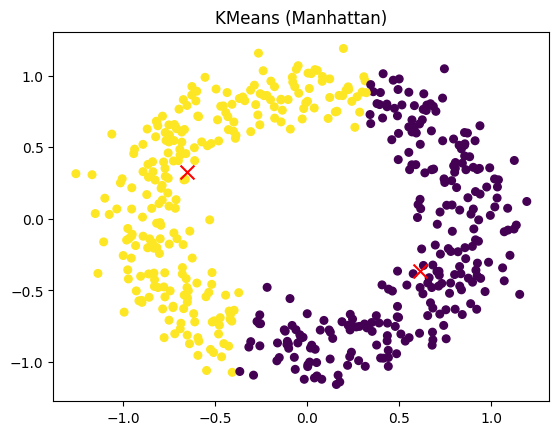

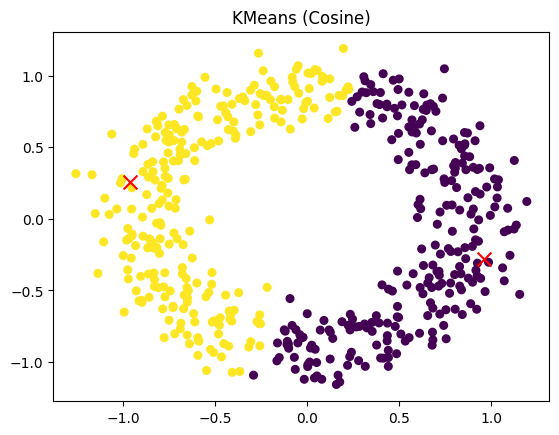

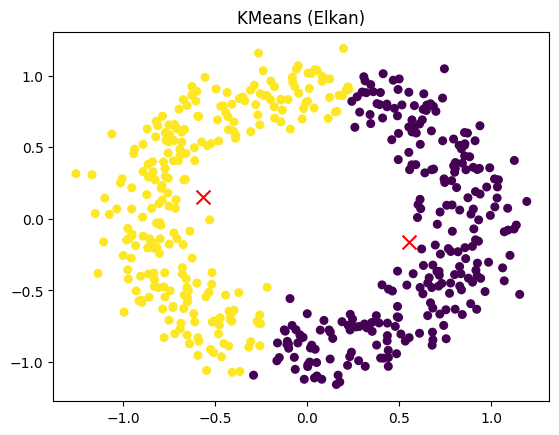

Silhouette Scores:
KMeans (Euclidean - Normal): 0.396
KMeans (Manhattan): 0.395
KMeans (Cosine): 0.396
KMeans (Elkan): 0.396


In [205]:
# Generate data
X, _ = make_circles(n_samples=500, noise=0.1, random_state=0)

# Run and visualize each model
models = {
    'KMeans (Euclidean - Normal)': CustomKMeans(n_clusters=2, init='k-means++', random_state=0),
    'KMeans (Manhattan)': KMeansL1(n_clusters=2, init='k-means++', random_state=0),
    'KMeans (Cosine)': KMeansCosine(n_clusters=2, init='k-means++', random_state=0),
    'KMeans (Elkan)': KMeansElkan(n_clusters=2, init='k-means++', random_state=0)
}

from sklearn.metrics import silhouette_score

scores = {}
for name, model in models.items():
    model.fit(X)
    labels = model.labels_
    score = silhouette_score(X, labels)
    scores[name] = score

    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30)
    plt.scatter(model.centroids[:, 0], model.centroids[:, 1], c='red', marker='x', s=100)
    plt.title(name)
    plt.show()

print("Silhouette Scores:")
for name, score in scores.items():
    print(f"{name}: {score:.3f}")


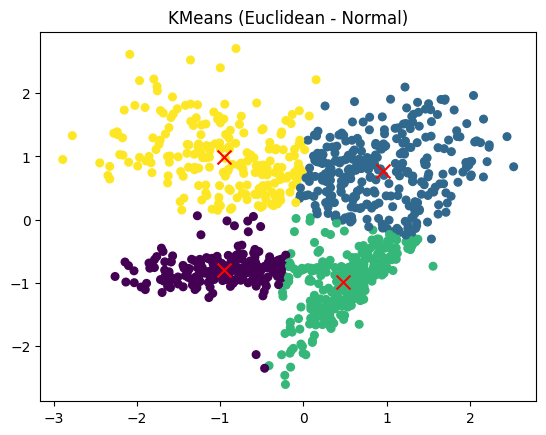

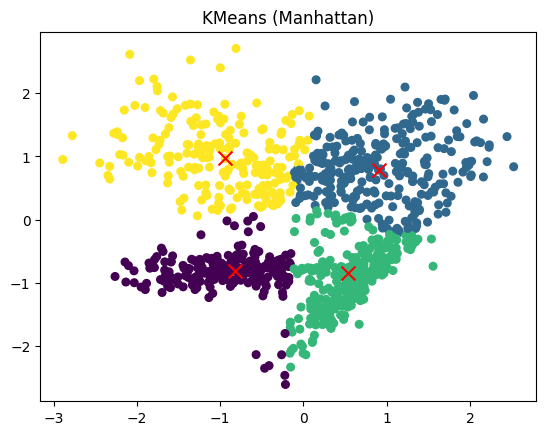

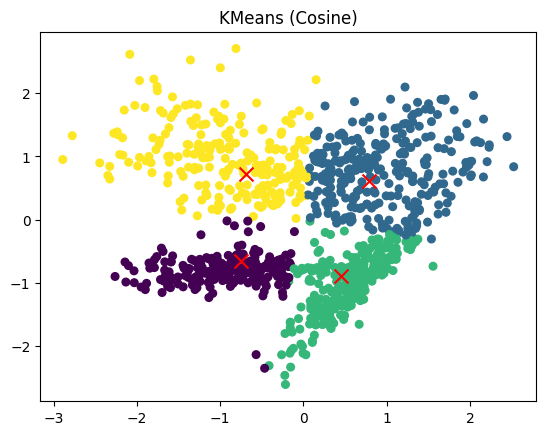

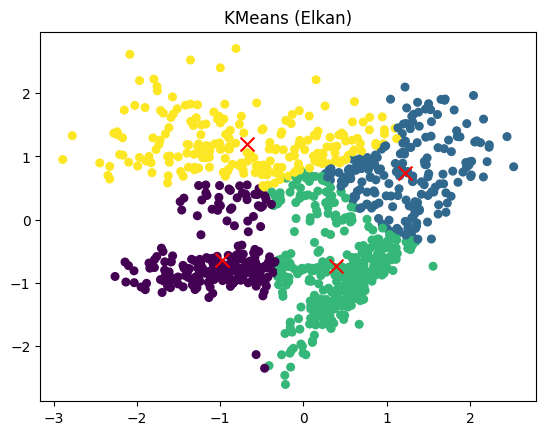

Silhouette Scores:
KMeans (Euclidean - Normal): 0.442
KMeans (Manhattan): 0.439
KMeans (Cosine): 0.443
KMeans (Elkan): 0.352


In [206]:
# Generate synthetic classification data
X, _ = make_classification(
    n_samples=1000,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    n_classes=4,
    random_state=0
)

#Normalize features
X = StandardScaler().fit_transform(X)

#Define and evaluate clustering models
models = {
    'KMeans (Euclidean - Normal)': CustomKMeans(n_clusters=4, init='k-means++', random_state=0),
    'KMeans (Manhattan)': KMeansL1(n_clusters=4, init='k-means++', random_state=0),
    'KMeans (Cosine)': KMeansCosine(n_clusters=4, init='k-means++', random_state=0),
    'KMeans (Elkan)': KMeansElkan(n_clusters=4, init='k-means++', random_state=0)
}

scores = {}
for name, model in models.items():
    model.fit(X)
    labels = model.labels_
    score = silhouette_score(X, labels)
    scores[name] = score

    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30)
    plt.scatter(model.centroids[:, 0], model.centroids[:, 1], c='red', marker='x', s=100)
    plt.title(name)
    plt.show()

print("Silhouette Scores:")
for name, score in scores.items():
    print(f"{name}: {score:.3f}")


More Minibatch KMeans testing


=== Anisotropic Dataset ===
CustomMiniBatchKMeans Silhouette Score: 0.7023
Sklearn MiniBatchKMeans Silhouette Score: 0.7023


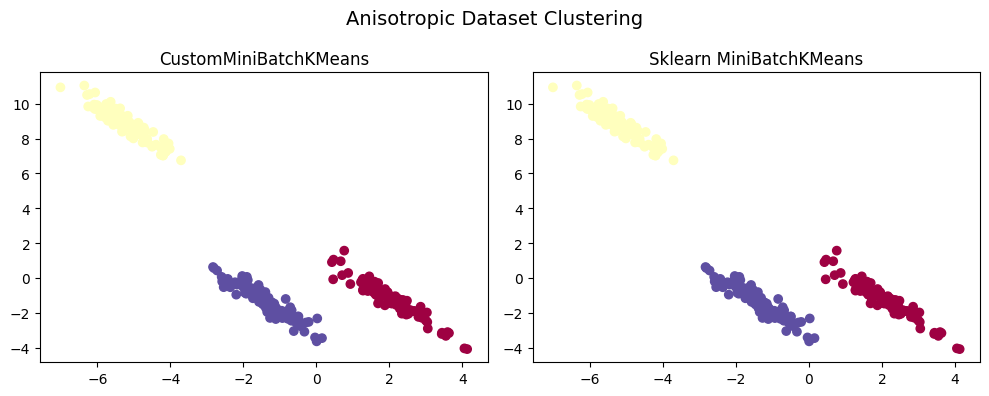


=== Iris Dataset ===
CustomMiniBatchKMeans Silhouette Score: 0.4384
Sklearn MiniBatchKMeans Silhouette Score: 0.3545


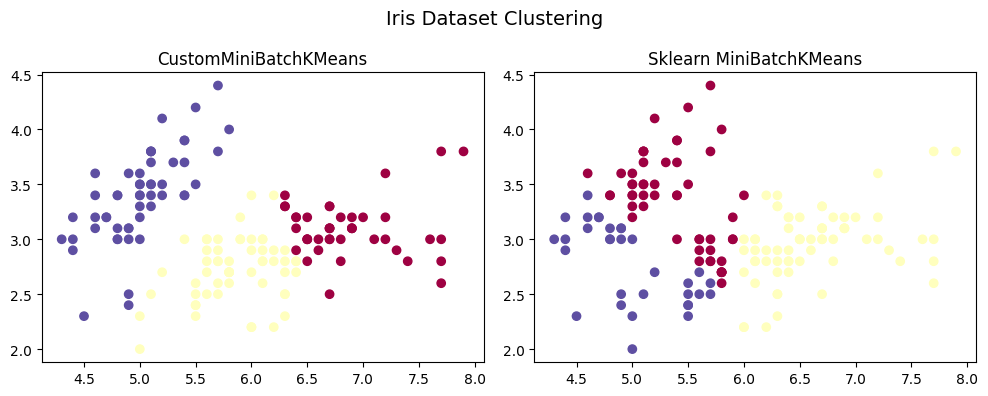


=== Wine Dataset ===
CustomMiniBatchKMeans Silhouette Score: 0.4760
Sklearn MiniBatchKMeans Silhouette Score: 0.4746


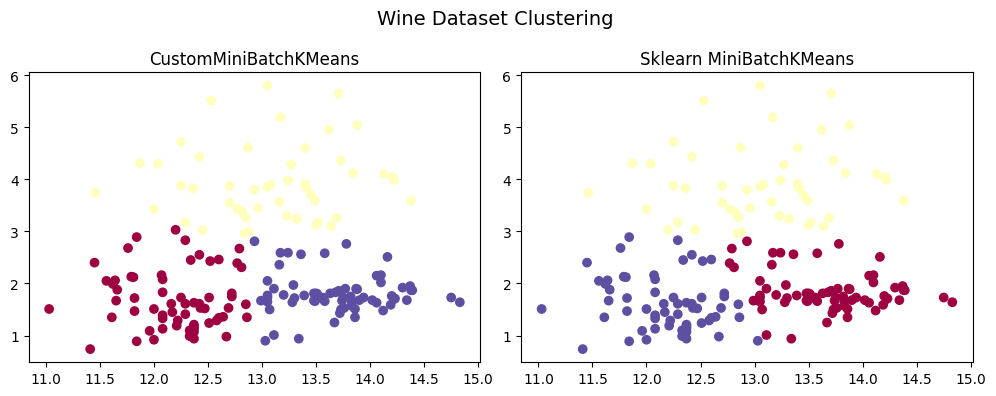

In [207]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, load_iris, load_wine
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

#Anisotropic Blobs
X_blob, _ = make_blobs(n_samples=300, random_state=42)
transformation = np.array([[0.6, -0.6], [-0.4, 0.8]])
X_aniso = X_blob @ transformation

#Iris Dataset
iris = load_iris()
X_iris = iris.data[:, :2]

#Wine Dataset (using the first 2 features for simplicity)
wine = load_wine()
X_wine = wine.data[:, :2]

datasets = {
    "Anisotropic": X_aniso,
    "Iris": X_iris,
    "Wine": X_wine
}

for name, X in datasets.items():
    print(f"\n{name} Dataset")

    #MiniBatchKMeans
    custom_model = CustomMiniBatchKMeans(n_clusters=3, batch_size=20, init='k-means++', random_state=42)
    custom_labels = custom_model.fit_predict(X)
    custom_score = silhouette_score(X, custom_labels)
    print(f"CustomMiniBatchKMeans Silhouette Score: {custom_score:.4f}")

    #Sklearn MiniBatchKMeans
    sklearn_model = MiniBatchKMeans(n_clusters=3, batch_size=20, init='k-means++', random_state=42)
    sklearn_labels = sklearn_model.fit_predict(X)
    sklearn_score = silhouette_score(X, sklearn_labels)
    print(f"Sklearn MiniBatchKMeans Silhouette Score: {sklearn_score:.4f}")

    #Plotting
    plt.figure(figsize=(10, 4))
    plt.suptitle(f"{name} Dataset Clustering", fontsize=14)

    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=custom_labels, cmap='Spectral')
    plt.title("CustomMiniBatchKMeans")

    plt.subplot(1, 2, 2)
    plt.scatter(X[:, 0], X[:, 1], c=sklearn_labels, cmap='Spectral')
    plt.title("Sklearn MiniBatchKMeans")

    plt.tight_layout()
    plt.show()




Anisotropic Dataset
CustomKMeans (k-means++) Silhouette Score: 0.7023
CustomKMeans (random)     Silhouette Score: 0.7023
Sklearn KMeans            Silhouette Score: 0.7023


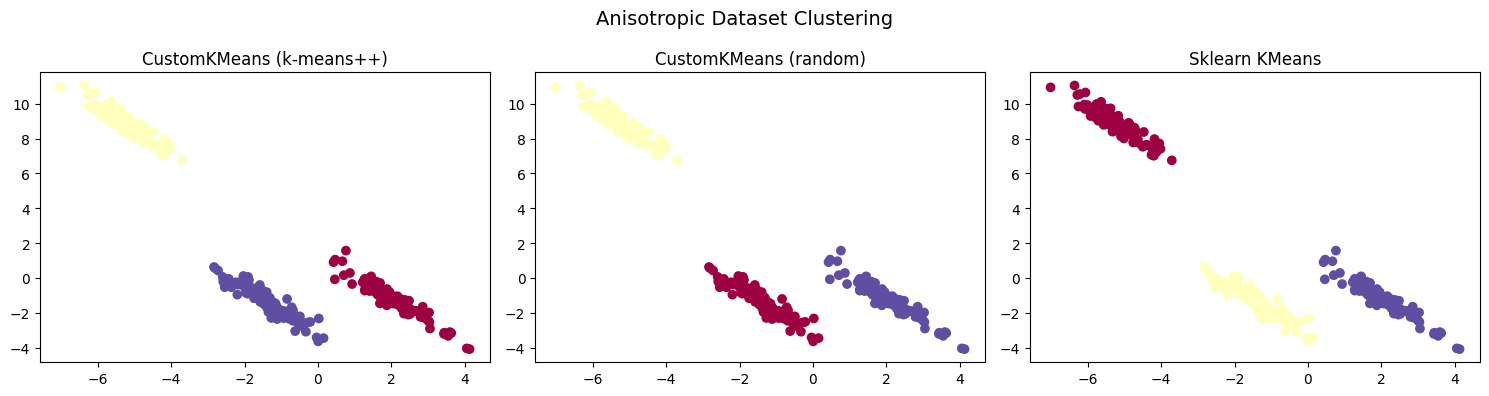


Iris Dataset
CustomKMeans (k-means++) Silhouette Score: 0.4424
CustomKMeans (random)     Silhouette Score: 0.4424
Sklearn KMeans            Silhouette Score: 0.4451


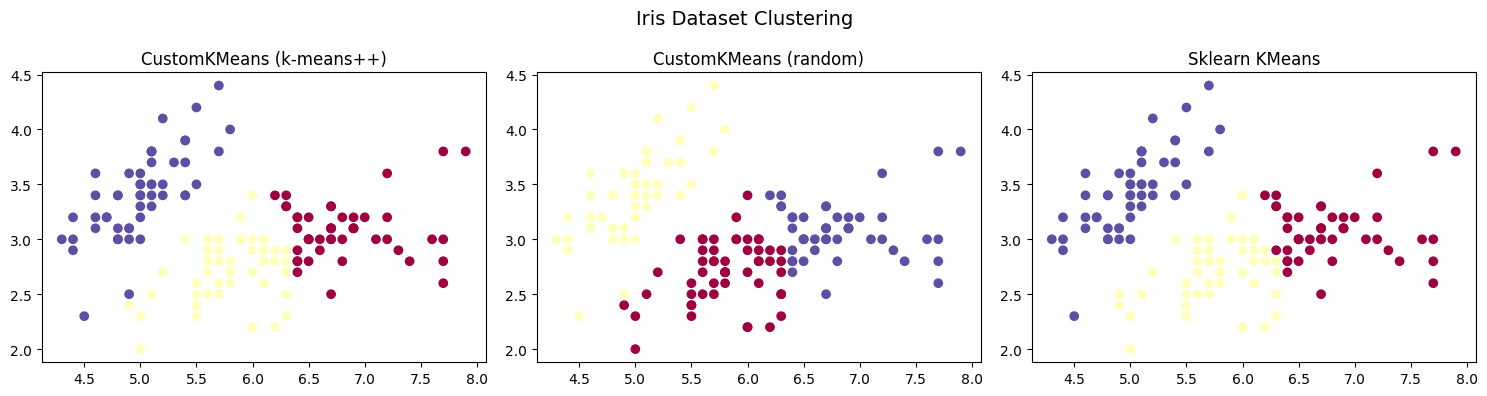


Wine Dataset
CustomKMeans (k-means++) Silhouette Score: 0.4807
CustomKMeans (random)     Silhouette Score: 0.4805
Sklearn KMeans            Silhouette Score: 0.4805


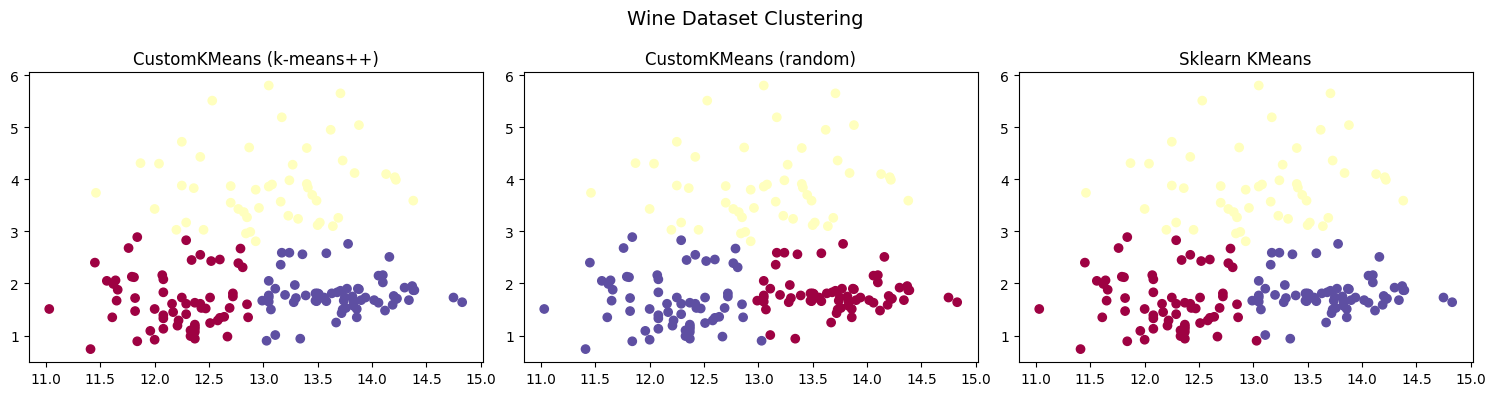

In [208]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, load_iris, load_wine
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Anisotropic data
X_blob, _ = make_blobs(n_samples=300, random_state=42)
transformation = np.array([[0.6, -0.6], [-0.4, 0.8]])
X_aniso = X_blob @ transformation

#Iris Dataset
iris = load_iris()
X_iris = iris.data[:, :2]  #Use first two features for visualization

#Wine Dataset
wine = load_wine()
X_wine = wine.data[:, :2]  #Use first two features for visualization

datasets = {
    "Anisotropic": X_aniso,
    "Iris": X_iris,
    "Wine": X_wine
}

for name, X in datasets.items():
    print(f"\n{name} Dataset")

    #CustomKMeans (k-means++)
    custom_kpp = CustomKMeans(n_clusters=3, init='k-means++', random_state=42, n_init=1)
    labels_kpp = custom_kpp.fit_predict(X)
    score_kpp = silhouette_score(X, labels_kpp)
    print(f"CustomKMeans (k-means++) Silhouette Score: {score_kpp:.4f}")

    #CustomKMeans (random init)
    custom_rand = CustomKMeans(n_clusters=3, init='random', random_state=42, n_init=1)
    labels_rand = custom_rand.fit_predict(X)
    score_rand = silhouette_score(X, labels_rand)
    print(f"CustomKMeans (random)     Silhouette Score: {score_rand:.4f}")

    #Sklearn KMeans
    sk_kmeans = KMeans(n_clusters=3, init='k-means++', n_init=1, random_state=42)
    labels_sk = sk_kmeans.fit_predict(X)
    score_sk = silhouette_score(X, labels_sk)
    print(f"Sklearn KMeans            Silhouette Score: {score_sk:.4f}")

    #Plotting
    plt.figure(figsize=(15, 4))
    plt.suptitle(f"{name} Dataset Clustering", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.scatter(X[:, 0], X[:, 1], c=labels_kpp, cmap='Spectral')
    plt.title("CustomKMeans (k-means++)")

    plt.subplot(1, 3, 2)
    plt.scatter(X[:, 0], X[:, 1], c=labels_rand, cmap='Spectral')
    plt.title("CustomKMeans (random)")

    plt.subplot(1, 3, 3)
    plt.scatter(X[:, 0], X[:, 1], c=labels_sk, cmap='Spectral')
    plt.title("Sklearn KMeans")

    plt.tight_layout()
    plt.show()
